In [1]:
# Import relevant packages
import pymaid
import seaborn as sns
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv
import CATMAID_CRED


In [2]:
# Initialize CATMAID
myInstance = CATMAID_CRED.CATMAID_CRED()

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [3]:
# A useful feature of pandas is that you can read CSV files directly into a dataframe.  Depending on how your data is organized, you may need to do more complicated parsing, but for our data, it's simple.
# Read in some skeleton data for the dbd neuron as a pandas dataframe and look at the general structure of the dataframe using the .head function.

treenode_table = pd.read_csv('treenodes.csv')
print(treenode_table.shape)
treenode_table.head(5)

(711, 13)


,Unnamed: 0,skeleton_id,treenode_id,parent_node_id,confidence,x,y,z,radius,creator,last_edited,reviewers,tags
0,0,6195521,6196689,6196688.0,5,49479.2,74457.2,122850.0,-1.0,albert,2014-04-08 18:03:15+00:00,"['aref', 'akira']",[]
1,1,6195521,13804384,13804385.0,5,48142.2,75547.8,123250.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]
2,2,6195521,13776295,13804396.0,5,47830.6,75475.6,123150.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]
3,3,6195521,13804386,13776295.0,5,48161.2,75498.4,123150.0,-1.0,aref,2015-04-16 22:58:37+00:00,"['aref', 'akira']",[]
4,4,6195521,13804396,13804397.0,5,48461.4,75205.8,123100.0,-1.0,aref,2014-06-25 21:29:05+00:00,"['aref', 'akira']",[]


In [ ]:
# Lets make sure we know what we are looking at.  We imported only one neuron.  Neurons in CATAMID are each given a unique identifier called a skeleton ID.  
# First, we can make sure we only have a single neuron in our dataframe by making sure we only have one skeleton ID present.
neuron_count = pd.unique(treenode_table.skeleton_id)
print(len(neuron_count))

# Next, lets see how big our neuron is.  Each node of a skeleton is given a unique treenode ID.  We can count the number of treenode_IDs to get a rough idea of how big the neuron is.
sk_node_count = pd.unique(treenode_table.treenode_id)
print(len(sk_node_count))

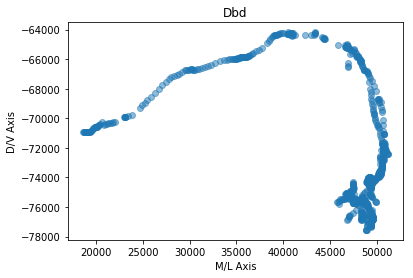

In [4]:
# The nice thing about dataframes is that we can use intuitive labels to index data.  For example, if we want to see what the neuron looks like,
# we can extract the coordinates of the neurons treenodes and plot them.  

plt.scatter(treenode_table.x, treenode_table.y*-1 , alpha=0.5)
plt.title('Dbd')
plt.xlabel('M/L Axis')
plt.ylabel('D/V Axis')
plt.show()

In [5]:
# We can also do a bit more complex indexing.  If, for example, we want to index based on location rather than the labels, we use .iloc
print(treenode_table.iloc[0:5,:])



   Unnamed: 0  skeleton_id  treenode_id  parent_node_id  confidence        x  \
0           0      6195521      6196689       6196688.0           5  49479.2   
1           1      6195521     13804384      13804385.0           5  48142.2   
2           2      6195521     13776295      13804396.0           5  47830.6   
3           3      6195521     13804386      13776295.0           5  48161.2   
4           4      6195521     13804396      13804397.0           5  48461.4   

         y         z  radius creator                last_edited  \
0  74457.2  122850.0    -1.0  albert  2014-04-08 18:03:15+00:00   
1  75547.8  123250.0    -1.0    aref  2014-06-25 21:29:05+00:00   
2  75475.6  123150.0    -1.0    aref  2014-06-25 21:29:05+00:00   
3  75498.4  123150.0    -1.0    aref  2015-04-16 22:58:37+00:00   
4  75205.8  123100.0    -1.0    aref  2014-06-25 21:29:05+00:00   

           reviewers tags  
0  ['aref', 'akira']   []  
1  ['aref', 'akira']   []  
2  ['aref', 'akira']   []  
3  [

In [ ]:
# We can even combine the two and index with both
print(treenode_table.loc[0:5,["x", "y", "z"]])

In [ ]:
# Now that we have a bit of an understanding of how pandas dataframes work, we can use a similar logic to start working with more complicated data and packages.
# The pymaid package was designed for working with skeletonized neuronal data generated in CATMAID.  CATMAID deals in a file format called JSONs.  Pymaid can either
# interface directly with CATMAID, or read in JSON files which contain relevant data for neurons.  For this example, we will use JSON files.

with open('demo_data.json', 'r') as f:
    json_neurons = json.load(f)

str_neurons = json.dumps(json_neurons)
nl = pymaid.json2neuron(str_neurons)

In [ ]:
# Now that we have a neuron list, we can explore how they are structured.  To start, lets just look at a summary
nl.summary


In [ ]:
# This summary is a dataframe, but the neuron list itself is a bit more complicated.  It stores a much larger amount of data than what the summary is showing.
# For example, the neuron list stores all of the synapse locations for all of the neurons.  
print(nl.connectors.head(10))



In [ ]:
# Whlie these data structures are a bit more complicated, we can think about them, and index them in the same way.  Let's combine a few things to plot the input and output sites for a single neuron.
# Notice the column 'relation'.  This column tells us if the connector is for a pre or post synaptic site.  If we index based on this column, we can separate inputs and outputs.  Syntax is 0 for presynapses, 1 for postsynapses.
plt.scatter(nl[1].connectors.x[nl[1].connectors.relation == 0], nl[1].connectors.y[nl[1].connectors.relation == 0]*-1 , alpha=0.5,c = 'r')
plt.scatter(nl[1].connectors.x[nl[1].connectors.relation == 1], nl[1].connectors.y[nl[1].connectors.relation == 1]*-1 , alpha=0.5, c = 'c')
plt.title(nl[1].neuron_name + 'Connectors')
plt.xlabel('M/L Axis')
plt.ylabel('D/V Axis')
plt.show()

In [ ]:
#  Now that we have a general idea of how the data is organized, we can do some more complicated plotting.  While a scatterplot of the treenodes is sort of useful for visualization, we can do far more complicated things if we think about
# the treenodes as part of a graph structure.  That is, if we consider the relationship between each of them.  H
treenode_table = nl[1].nodes
print(treenode_table.head(5))



In [ ]:
# If we look at the treenode table, we see the column with the treenode ids, and another column called parent_node_ids.  These two columns provide the relationship between one treenode and another, and allows us to 
# build a connected graph representation of the neuron.  We won't go into how exactly to do that today, but we can plot the graph representation of the neuron.  There is a special graph function built into the 
# pymaid package that allows us to plot these graph structures, as well as some other cool options like adding synapses.
fig, ax = nl[1].plot2d(color='k',connectors=True,cn_size=15,figsize = [15,15])

In [ ]:
# The reason using graph structures to represent neurons is useful is because we can then do things like measure geodesic distances between points, cut neurons at different places, segment neurons into meaningful fragments,
# and build anatomically enriched wiring diagrams. To demonstrate this, lets cut A08a somewhere.

# First, we need to make sure the graph is directed towards a meaninful point so that if we cut it, we will get the pieces we want.  The best option is to reroot the graph at the soma.  

nl[1].reroot(nl[1].soma, inplace=True)
# Next we need to get the treenode IDs for this neuron in order to get a cut point
tn = pymaid.get_treenode_table(nl[1])
# Now cut the neuron using the cut_neuron function and plot the results.
cut = pymaid.cut_neuron(nl[1], tn.treenode_id[400])
fig, ax = pymaid.plot2d(cut, connectors=True, linewidth=1.5, cn_size = 15)
fig, ax = pymaid.plot2d(cut[0], connectors=True, linewidth=1.5, cn_size = 15)
fig, ax = pymaid.plot2d(cut[1], connectors=True, linewidth=1.5, cn_size = 15)

# You can imagine the possibilities of using these tools to look at compartmentalization of inputs, 
# morphological features of different pieces of a neuron, and more.

In [ ]:
# For example, the cut point I specified is more or less a rough approximation of the axon and dendrite. If we were interested inputs onto A08a that are axo-axonic, we could cut the neuron to separate the axon, and then get all inputs onto just the axon portion.
axon = cut[0]
cn_table_axon = pymaid.cn_table_from_connectors(axon)
cn_table_axon = cn_table_axon[cn_table_axon.relation == 'upstream']
axonic_inputs = pymaid.get_neurons(np.array(cn_table_axon.skeleton_id))
axonic_inputs = axonic_inputs[axonic_inputs.n_nodes > 1]
fig,ax = pymaid.plot2d(axonic_inputs,color = 'r',figsize = [15,15],alpha = .25)
ax = pymaid.plot2d(cut,color = 'b',ax=ax)

In [ ]:
# Now that we know some basics about plotting and morphology, we can turn our attention to connectivity.  A simple way to do this is to generate a connectivity matrix between the neurons in our dataset.
neuron_adj = pymaid.adjacency_matrix(nl)
g = sns.heatmap(neuron_adj, square=True)
g.set_yticklabels(nl.neuron_name, rotation=0, fontsize=14)
g.set_xticklabels(nl.neuron_name, rotation=90, fontsize=14)
plt.show()

g2 = sns.heatmap(neuron_adj+np.transpose(neuron_adj), square=True)
g2.set_yticklabels(nl.neuron_name, rotation=0, fontsize=14)
g2.set_xticklabels(nl.neuron_name, rotation=90, fontsize=14)
plt.show()

# Often times, the number of synapses does not necessarily mean very much.  Neurons with large dendrites and lots of inputs will respond differently to a single input than small neurons with few inputs.
# Therefore it is often useful to calculate the number of synapses 

In [ ]:
neuron = nl[1]
neuron = pymaid.strahler_index(nl[1],inplace=False)
index_1 = neuron.nodes.treenode_id.loc[neuron.nodes.strahler_index == 1]
index_2 = neuron.nodes.treenode_id.loc[neuron.nodes.strahler_index == 2]
index_3 = neuron.nodes.treenode_id.loc[neuron.nodes.strahler_index == 3]
index_4 = neuron.nodes.treenode_id.loc[neuron.nodes.strahler_index == 4]
index_5 = neuron.nodes.treenode_id.loc[neuron.nodes.strahler_index == 5]

In [ ]:
s1 = pymaid.subset_neuron(neuron,np.array(index_1))
s2 = pymaid.subset_neuron(neuron,np.array(index_2))
s3 = pymaid.subset_neuron(neuron,np.array(index_3))
s4 = pymaid.subset_neuron(neuron,np.array(index_4))
s5 = pymaid.subset_neuron(neuron,np.array(index_5))

In [ ]:
fig, ax = pymaid.plot2d(s5, connectors=False, linewidth=2.5,color = 'k',figsize = [15,15])
fig, ax = pymaid.plot2d(s1, connectors=False, linewidth=2.5,color = 'r',figsize = [15,15], ax = ax)
fig, ax = pymaid.plot2d(s2, connectors=False, linewidth=2.5,color = 'y',figsize = [15,15], ax = ax)
fig, ax = pymaid.plot2d(s3, connectors=False, linewidth=2.5,color = 'g',figsize = [15,15], ax = ax)
fig, ax = pymaid.plot2d(s4, connectors=False, linewidth=2.5,color = 'b',figsize = [15,15], ax = ax)


